In [1]:
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.functional import pad, log_softmax
from pathlib import Path
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
from model import Transformer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 256
epochs = 1
save_after_step = 100
max_length = 72
use_cache = True
model_checkpoint=False
d_model = 512     # 模型维度
d_ffn = 2048
nhead = 8         # 多头注意力的头数
dropout = 0.1
num_encoder_layers = 6  # 编码器层数
num_decoder_layers = 6  # 解码器层数
en_vocab_size=22776
zh_vocab_size=4726
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [3]:
en_filepath = 'data/news-commentary-v15.en'
zh_filepath = 'data/news-commentary-v15.zh'
def get_row_count(filepath):
    count = 0
    with open(filepath, encoding='utf-8-sig') as file:
        for line in file:
            count += 1
    return count
en_row_count = get_row_count(en_filepath)
zh_row_count = get_row_count(zh_filepath)
assert en_row_count == zh_row_count, "英文和中文文件行数不一致！"
row_count = en_row_count
print("句子数量为：", en_row_count)
print("句子最大长度为：", max_length)

句子数量为： 320713
句子最大长度为： 72


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def en_tokenizer(line):
    """
    定义英文分词器，后续也要使用
    :param line: 一句英文句子，例如"I'm learning Deep learning."
    :return: subword分词后的记过，例如：['i', "'", 'm', 'learning', 'deep', 'learning', '.']
    """
    return tokenizer.tokenize(line, add_special_tokens=False)

def zh_tokenizer(line):
    """
    定义中文分词器
    :param line: 中文句子，例如：机器学习
    :return: 分词结果，例如['机','器','学','习']
    """
    return list(line.strip().replace(" ", ""))
    
def yield_en_tokens():
    file = open(en_filepath, encoding='utf-8')
    print("-------开始构建英文词典-----------")
    for line in tqdm(file, desc="构建英文词典", total=row_count):
        yield en_tokenizer(line)
    file.close()

def yield_zh_tokens():
    file = open(zh_filepath, encoding='utf-8')
    print("-------开始构建中文词典-----------")
    for line in tqdm(file, desc="构建中文词典", total=row_count):
        yield zh_tokenizer(line)
    file.close()
    

en_vocab_file = "vocab_en.pt"
if os.path.exists(en_vocab_file):
    en_vocab = torch.load(en_vocab_file, map_location="cpu")
else:
    en_vocab = build_vocab_from_iterator(yield_en_tokens(), min_freq=2, specials=["<s>", "</s>", "<pad>", "<unk>"])
    en_vocab.set_default_index(en_vocab["<unk>"])
    torch.save(en_vocab, en_vocab_file)
print("英文词典大小:", len(en_vocab))

zh_vocab_file = "vocab_zh.pt"
if os.path.exists(zh_vocab_file):
    zh_vocab = torch.load(zh_vocab_file, map_location="cpu")
else:
    zh_vocab = build_vocab_from_iterator(yield_zh_tokens(), min_freq=1, specials=["<s>", "</s>", "<pad>", "<unk>"])
    zh_vocab.set_default_index(zh_vocab["<unk>"])
    torch.save(zh_vocab, zh_vocab_file)
print("中文词典大小:", len(zh_vocab))

英文词典大小: 22776
中文词典大小: 4726


In [5]:
def load_tokens(file, tokenizer, vocab, desc, lang):
    """
    加载tokens，即将文本句子们转换成index们。
    :param file: 文件路径，例如"./dataset/train.en"
    :param tokenizer: 分词器，例如en_tokenizer函数
    :param vocab: 词典, Vocab类对象。例如 en_vocab
    :param desc: 用于进度显示的描述，例如：构建英文tokens
    :param lang: 语言。用于构造缓存文件时进行区分。例如：’en‘
    :return: 返回构造好的tokens。例如：[[6, 8, 93, 12, ..], [62, 891, ...], ...]
    """
    # 定义缓存文件存储路径
    cache_file = "tokens_list.{}.pt".format(lang)
    if os.path.exists(cache_file):
        print(f"正在加载缓存文件{cache_file}, 请稍后...")
        return torch.load(cache_file, map_location="cpu")
    tokens_list = []
    with open(file, encoding='utf-8') as file:
        for line in tqdm(file, desc=desc, total=row_count):
            tokens = tokenizer(line)
            tokens = vocab(tokens)
            tokens_list.append(tokens)
    torch.save(tokens_list, cache_file)
    return tokens_list

en_tokens=load_tokens(en_filepath, en_tokenizer, en_vocab, "构建英文tokens", 'en')
zh_tokens=load_tokens(zh_filepath, zh_tokenizer, zh_vocab, "构建中文tokens", 'zh')

正在加载缓存文件tokens_list.en.pt, 请稍后...
正在加载缓存文件tokens_list.zh.pt, 请稍后...


In [6]:
train_size = int(0.8 * row_count)
valid_size = int(0.1 * row_count)
en_train = en_tokens[:train_size]
zh_train = zh_tokens[:train_size]
en_valid = en_tokens[train_size:train_size + valid_size]
zh_valid = zh_tokens[train_size:train_size + valid_size]
en_test = en_tokens[train_size + valid_size:]
zh_test = zh_tokens[train_size + valid_size:]


class TranslationDataset(Dataset):
    def __init__(self, en_tokens, zh_tokens):
        self.en_tokens = en_tokens
        self.zh_tokens = zh_tokens

    def __getitem__(self, index):
        return self.en_tokens[index], self.zh_tokens[index]

    def __len__(self):
        return len(self.en_tokens)

train_dataset = TranslationDataset(en_train,zh_train)
valid_dataset = TranslationDataset(en_valid,zh_valid)
test_dataset = TranslationDataset(en_test,zh_test)

In [7]:
def collate_fn(batch):
    bs_id = torch.tensor([0])
    eos_id = torch.tensor([1])
    pad_id = 2
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat([bs_id,torch.tensor(_src, dtype=torch.int64),eos_id,],0)
        processed_tgt = torch.cat([bs_id,torch.tensor(_tgt, dtype=torch.int64),eos_id,],0)
        src_list.append(pad(processed_src, (0, max_length - len(processed_src)), value=pad_id))
        tgt_list.append(pad(processed_tgt, (0, max_length - len(processed_tgt)), value=pad_id))
    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    tgt_y = tgt[:, 1:]
    tgt = tgt[:, :-1]
    n_tokens = (tgt_y != 2).sum()
    return src, tgt, tgt_y, n_tokens

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [8]:
class TranslationLoss(nn.Module):
    def __init__(self):
        super(TranslationLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = 2

    def forward(self, x, target):
        true_dist = torch.zeros(x.size()).to(device)
        true_dist.scatter_(1, target.data.unsqueeze(1), 1)
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        return self.criterion(x, true_dist.clone().detach())

model = Transformer(en_vocab_size, zh_vocab_size, d_model, d_ffn, nhead, dropout, num_encoder_layers, num_decoder_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criteria = TranslationLoss()

In [9]:
def train():
    step = 0
    train_loss_list = []
    val_loss_list = []
    val_bleu1_list = []
    val_bleu4_list = []
    step_list = []
    for epoch in range(epochs):
        train_loss = 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader))
        for index, (src, tgt, tgt_y, n_tokens) in enumerate(train_loader):
            model.train()
            src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
            optimizer.zero_grad()
            out = model(src, tgt)
            loss = criteria(out.contiguous().view(-1, out.size(-1)), tgt_y.contiguous().view(-1)) / n_tokens
            loss.backward()
            train_loss+=loss.item()
            optimizer.step()
            loop.set_description("Epoch {}/{}".format(epoch, epochs))
            loop.set_postfix(loss=loss.item())
            loop.update(1)
            step+=1
            if step != 0 and step % save_after_step == 0:
                val_loss, val_bleu1, val_bleu4 = val(test=False)
                train_loss /= save_after_step
                train_loss_list.append(train_loss)
                val_loss_list.append(val_loss)
                val_bleu1_list.append(val_bleu1)
                val_bleu4_list.append(val_bleu4)
                step_list.append(step)
                train_loss=0
                print("val_loss:{},val_bleu1:{},val_bleu4:{}".format(val_loss,val_bleu1,val_bleu4))
    return train_loss_list, val_loss_list, val_bleu1_list,val_bleu4_list, step_list

def val(test):
    model.eval()
    val_loader = valid_loader if test==False else test_loader
    val_loss = val_bleu1 = val_bleu4 = 0
    tgt_y_list = []
    pred_y_list = []
    for index, (src, tgt, tgt_y, n_tokens) in enumerate(val_loader):
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        with torch.no_grad():
            out = model(src, tgt)
        pred_y = torch.argmax(out, dim=-1)
        loss = criteria(out.contiguous().view(-1, out.size(-1)), tgt_y.contiguous().view(-1)) / n_tokens
        val_loss +=loss.item()
        for yy in tgt_y.cpu().tolist():
            tgt_y_list.append(zh_vocab.lookup_tokens(yy))
        for yy in pred_y.cpu().tolist():
            pred_y_list.append(zh_vocab.lookup_tokens(yy))
    for out, tar in zip(pred_y_list, tgt_y_list):
        val_bleu1 += sentence_bleu([tar], out, weights=(1, 0, 0, 0))
        val_bleu4 += sentence_bleu([tar], out, weights=(0, 0, 0, 1))
    val_loss /= len(val_loader)
    val_bleu1 /= len(val_loader)
    val_bleu4 /= len(val_loader)
    return val_loss, val_bleu1, val_bleu4

def translate(src: str):
    model.eval()
    src = torch.tensor([0] + en_vocab(en_tokenizer(src)) + [1]).unsqueeze(0).to(device)
    tgt = torch.tensor([[0]]).to(device)
    for i in range(max_length):
        out = model(src, tgt)
        predict = model.predictor(out[:, -1])
        y = torch.argmax(predict, dim=1)
        
        tgt = torch.concat([tgt, y.unsqueeze(0)], dim=1)
        if y == 1:
            break
    tgt = ''.join(zh_vocab.lookup_tokens(tgt.squeeze().tolist())).replace("<s>", "").replace("</s>", "")
    return tgt

Epoch 0/1:  10%|▉         | 100/1003 [00:48<07:31,  2.00it/s, loss=4.65]

val_loss:4.620581017600165,val_bleu1:48.12597809076835,val_bleu4:0.12628384687208447


Epoch 0/1:  20%|█▉        | 200/1003 [02:28<06:25,  2.08it/s, loss=4.27]  

val_loss:4.209968801528689,val_bleu1:55.00581265370148,val_bleu4:0.29190009337069206


Epoch 0/1:  30%|██▉       | 300/1003 [04:08<05:53,  1.99it/s, loss=3.93]  

val_loss:3.8750570161002025,val_bleu1:60.98144422088207,val_bleu4:1.1782212885153882


Epoch 0/1:  40%|███▉      | 400/1003 [05:49<04:57,  2.03it/s, loss=3.62]  

val_loss:3.5924150641002353,val_bleu1:67.13827408897913,val_bleu4:2.651027077497223


Epoch 0/1:  50%|████▉     | 500/1003 [07:31<04:11,  2.00it/s, loss=3.43]  

val_loss:3.3839570794786726,val_bleu1:71.24033087413461,val_bleu4:3.7763772175529695


Epoch 0/1:  60%|█████▉    | 600/1003 [09:12<03:23,  1.98it/s, loss=3.33]  

val_loss:3.2332302842821394,val_bleu1:73.87424547283852,val_bleu4:5.111694677870041


Epoch 0/1:  70%|██████▉   | 700/1003 [10:53<02:29,  2.02it/s, loss=3.13]  

val_loss:3.1117645748077876,val_bleu1:76.43773753633013,val_bleu4:6.117763772174197


Epoch 0/1:  80%|███████▉  | 800/1003 [12:36<01:42,  1.99it/s, loss=3.06]  

val_loss:3.008940541555011,val_bleu1:78.37704001788491,val_bleu4:7.1751867413617125


Epoch 0/1:  90%|████████▉ | 900/1003 [14:17<00:51,  2.00it/s, loss=2.91]

val_loss:2.9159548528610713,val_bleu1:79.50458305387967,val_bleu4:8.097805788980672


Epoch 0/1: 100%|█████████▉| 1000/1003 [15:58<00:01,  1.94it/s, loss=2.89]

val_loss:2.836310350705707,val_bleu1:81.01799687010953,val_bleu4:8.85562558356479


Epoch 0/1: 100%|██████████| 1003/1003 [16:50<00:00,  1.01s/it, loss=2.8] 


10


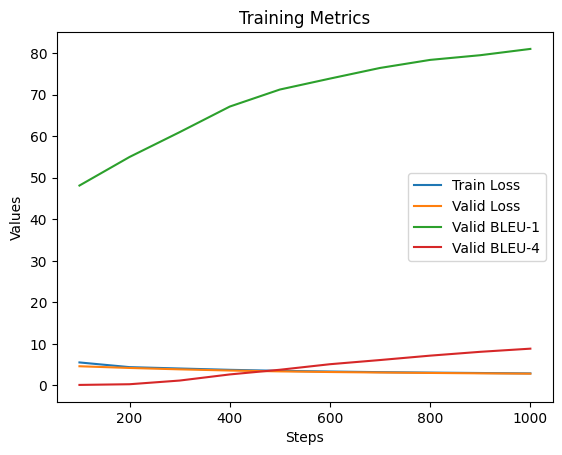

In [10]:
train_loss_list, val_loss_list, val_bleu1_list,val_bleu4_list, step_list = train()
val(test=True)
# 绘制图像
print(len(train_loss_list))
plt.plot(step_list, train_loss_list, label='Train Loss')
plt.plot(step_list, val_loss_list, label='Valid Loss')
plt.plot(step_list, val_bleu1_list, label='Valid BLEU-1')
plt.plot(step_list, val_bleu4_list, label='Valid BLEU-4')

# 添加标签和标题
plt.xlabel('Steps')
plt.ylabel('Values')
plt.title('Training Metrics')

# 添加图例
plt.legend()

# 保存图像到本地
plt.savefig('metrics.png')

# 显示图像（可选）
plt.show()

In [11]:
print(val(test=True))

(2.7430548289465526, 81.7966689023029, 9.988445378148882)
